In [1]:
import einops
import torch

from einops.layers.torch import EinMix

from utils.components import *
from utils.config import *
from utils.einmask import EinMask

from utils.masking import *

import itertools

In [2]:
import matplotlib.pyplot as plt

In [3]:
world = WorldConfig(field_sizes={"v": 6, "t": 36, "h": 64, "w": 120}, patch_sizes={'vv': 2, 'tt': 6, 'hh': 4, 'ww': 4}, batch_size=16)

In [37]:
network = NetworkConfig(dim=512, num_latents=32, num_layers=12, num_tails=4, use_checkpoint=False, dim_in=256, dim_coords=64,
                        wavelengths=[(1,8),(1,8),(1,64),(1,128)])

In [38]:
cpe = ContinuousPositionalEmbedding(
    network.dim_coords, network.wavelengths
)

In [39]:
model = EinMask(network=network, world=world)

In [40]:
p = cpe(model.coordinates)

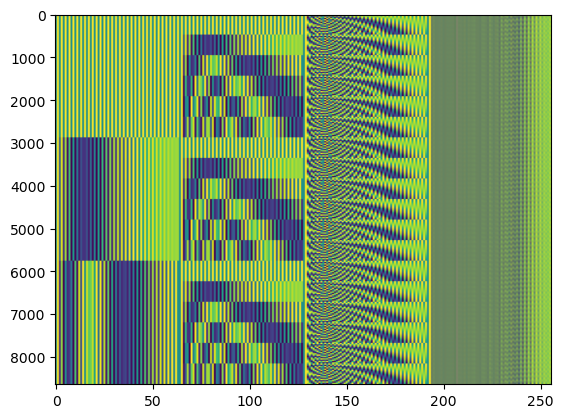

In [41]:
plt.imshow(p, aspect="auto")

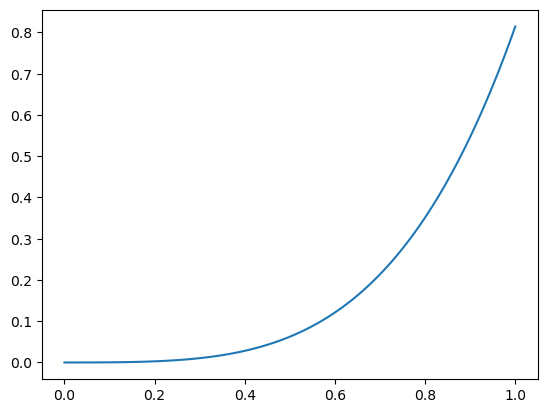

In [44]:
u = torch.linspace(0,1,100)
c0 = 1
c1 = 0.25
km = KumaraswamySchedule(objective=ObjectiveConfig(c1=c1, c0=c0))
plt.plot(u, km(u)[0])

Text(0, 0.5, 'masking rate')

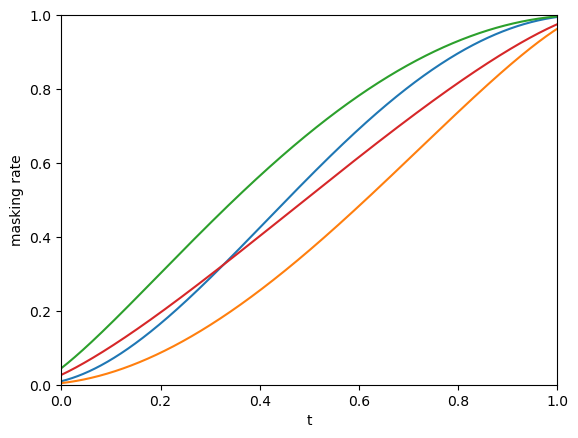

In [17]:
u = torch.linspace(0,1,1000)

for c1, c0 in itertools.product([0.5, 0.75],[0.5, 0.75]):
    km = KumaraswamySchedule(objective=ObjectiveConfig(c1=c1, c0=c0))
    plt.plot(u, km(u)[0])

plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('t')
plt.ylabel('masking rate')